# Evolutionary Dynamics in finite populations

In [36]:
import os
import sys, getopt
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
# %config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.filterwarnings('ignore')

This Jupyter notebook contains the code for producing the finite population dynamics of the iterated prisoners dilemma.  As a first step a number of global variables are defined. 

In [37]:
Z=50       # Population size
T=5.        # Temptation to defect
R=3.        # Reward for mutual cooperation
P=1.        # Punishment for mutual defection
S=0.        # Suckers payoff for unilateral cooperation
q=4         # Number of strategies
rounds=10   # Number of rounds
drift=1.0/Z # Random drift between strategies
beta=10   # Intensity of selection

Define here the label for each strategy and their payoff. You must **calculate yourself** the payoffs of each h when facing another q in a population of k individuals of strategy h and Z-k individuals of strategy q.

In [38]:
# Strategy labels
strats=['C','D', 'TFT', 'RANDOM'] # 1, 2, 3, 4
# Payoffs of each strategy when facing each other (order: 11, 12, 13, 14, 21...)
payoff=np.array([lambda k: 30, # Here C vs C
                 lambda k: 0 , # Here C vs D
                 lambda k: 30, # Here C vs TFT
                 lambda k: 15, # Here C vs RANDOM
                 lambda k: 40, # Here D vs C
                 lambda k: 10, # Here D vs D
                 lambda k: 13, # Here D vs TFT
                 lambda k: 25, # Here D vs RANDOM
                 lambda k: 30, # Here TFT vs C
                 lambda k: 9, # Here TFT vs D
                 lambda k: 30, # Here TFT vs TFT
                 lambda k: 19.5, # Here TFT vs RANDOM
                 lambda k: 35, # Here RANDOM vs C
                 lambda k: 5, # Here RANDOM vs D
                 lambda k: 21.5, # Here RANDOM vs TFT
                 lambda k: 20  # Here RANDOM vs RANDOM
                ]).reshape(q,q)

Using these global variables one can now calculate the fixation probabilities (assuming the small mutation limit).  A number of helper functions are defined 

In [39]:
def fitness(k,invader, resident):
    '''
    The fitness function determines the average payoff of k invaders and Z-k residents
    in the popiulation of N players. 
    '''
    resultA=(((k-1)*payoff[invader][invader](k))+((Z-k)*payoff[invader, resident](Z-k)))/float(Z-1)
    resultB=((k*payoff[resident][invader](k))+((Z-k-1)*payoff[resident, resident](Z-k)))/float(Z-1)
    return [resultA, resultB]

def fermifunc(b,first, second):
    '''
    The fermi function determines the probability that the first type imitates the second
    '''
    return 1./(1. + np.exp(-b*(first-second)))

def probIncreaseDecrease(k, invader, resident):
    '''
    This function calculates for a give number of invaders the probability 
    that the number increases or decreases with one. 
    '''
    fitvalue=fitness(k, invader, resident)
    increase=np.clip(((Z-k)/float(Z))*(k/float(Z))*fermifunc(-beta, fitvalue[1],fitvalue[0]), 0., 1.)
    decrease=np.clip(((Z-k)/float(Z))*(k/float(Z))*fermifunc(beta, fitvalue[1],fitvalue[0]), 0., 1.)
    return [increase,decrease]

def fixation(invader, resident):
    '''
    function for calculating the fixation probability of the invader 
    in a population of residents
    '''
    divideT = lambda x: x[1] / float(x[0])
    phi = [np.product([divideT(probIncreaseDecrease(j,invader, resident)) for j in range(1, i+1)]) for i in range(0, Z)]
    return np.clip((1 / np.sum(phi)), 0., 1.)

def transition_and_fixprob_matrix():
    transitions=np.zeros((q,q))
    fixprobs=np.zeros((q,q))
    for first in range(q):
        transitions[first,first]=1.
        for second in range(q) :
            if second != first :
                fp=fixation(second, first) 
                fixprobs[first][second]=(fp/drift)
                transitions[first][second]=fp/float(q-1)
                transitions[first][first]=transitions[first][first]-(fp/float(q-1))
    return [transitions,fixprobs]



Now we can start calculating the fixation probabilities between all pairs of strategies, which provides the transition matrix of the Markov chain.  Taking the 

In [40]:

t,f=transition_and_fixprob_matrix()
#print f
#print t

#calculate stationary distributions using eigenvalues and eigenvectors
w,v=np.linalg.eig(t.transpose())
j_stationary=np.argmin(abs(w-1.0)) #look for the element closest to 1 in the list of eigenvalues
p_stationary=abs(v[:,j_stationary].real) # the, is essential to access the matrix by column
p_stationary /= p_stationary.sum() #normalize

print ("transition probabilities (1st %s, 2nd %s, 3rd %s, 4th %s and read as row invading column) \n %s\n" %(*[i for i in strats],f))
print ("stationary distribution (1st %s, 2nd %s, 3rd %s, 4th %s) \n %s" %(*[i for i in strats], p_stationary))


transition probabilities (1st C, 2nd D, 3rd TFT, 4th RANDOM and read as row invading column) 
 [[  0.00000000e+00   5.00000000e+01   1.00000000e+00   5.00000000e+01]
 [  0.00000000e+00   0.00000000e+00   2.65743276e-08   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.00000000e+01   7.10216982e-04   0.00000000e+00]]

stationary distribution (1st C, 2nd D, 3rd TFT, 4th RANDOM) 
 [  2.65746083e-10   9.99999973e-01   2.68402464e-08   2.65744411e-10]


Now let's see how the stationary distributions change as a function of beta.

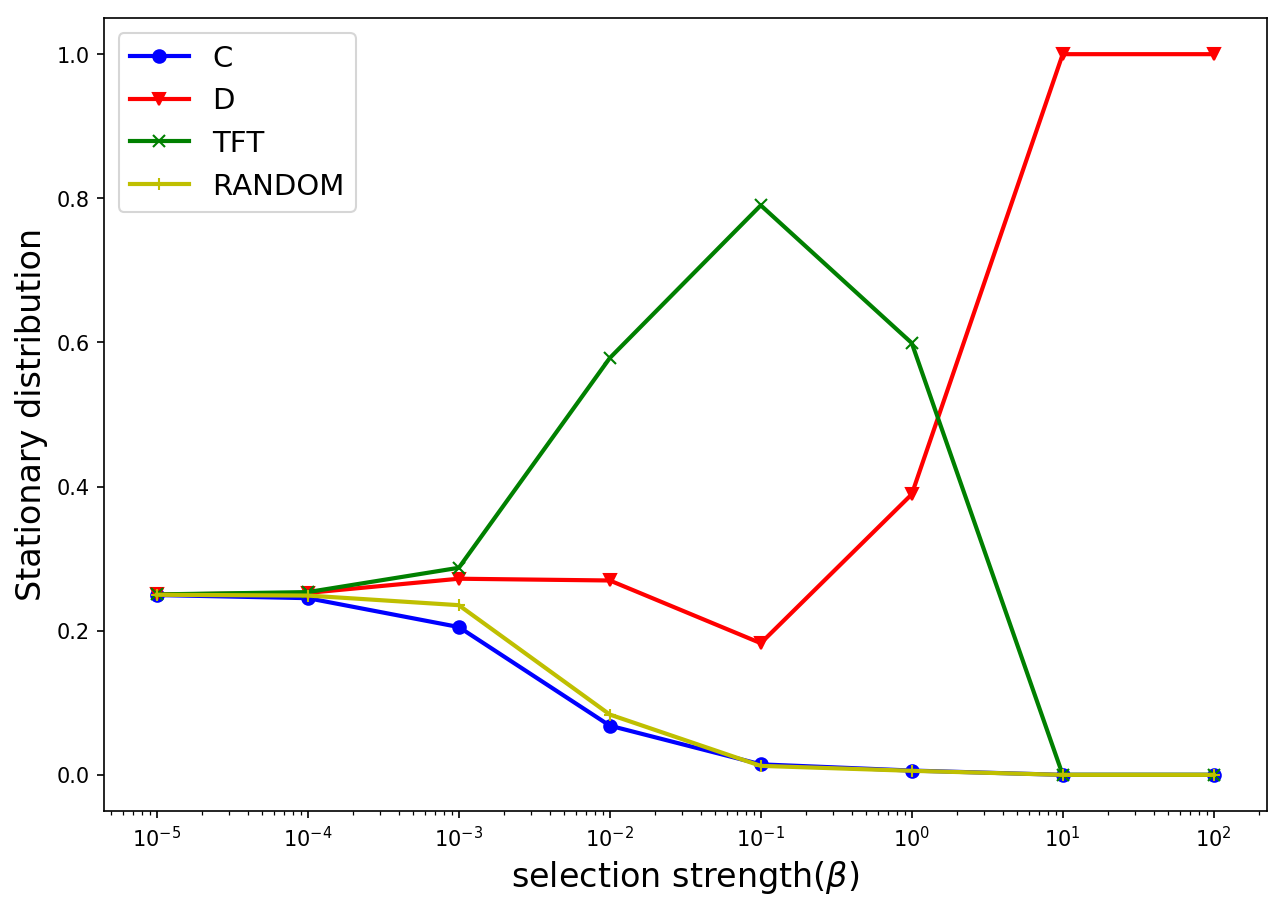

In [41]:
distribution=[]
betas=[0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for beta in betas:
    t,f=transition_and_fixprob_matrix()
    w,v=np.linalg.eig(t.transpose())
    j_stationary=np.argmin(abs(w-1.0)) 
    p_stationary=abs(v[:,j_stationary].real) 
    p_stationary /= p_stationary.sum()
    distribution.append(p_stationary)

darray=np.asarray(distribution)

fig = plt.figure(figsize=(10, 7), dpi=150)
lines=plt.plot(betas,darray[:,0],'bo-',
               betas,darray[:,1],'rv-', 
               betas,darray[:,2],'gx-',
               betas,darray[:,3],'y+-')
plt.rc("font", size=14)
plt.xscale('log')
plt.setp(lines, linewidth=2.0)
plt.ylabel('Stationary distribution',size=16)
plt.xlabel('selection strength'+r'($\beta$)',size=16)
plt.ylim(-0.05,1.05)
plt.legend(strats)
# plt.show()

So now lets look at the gradient of selection g(x): determine for different combinations of cooperators and defectors the difference between T+ and T-. Test how the gradient varies for different beta values.

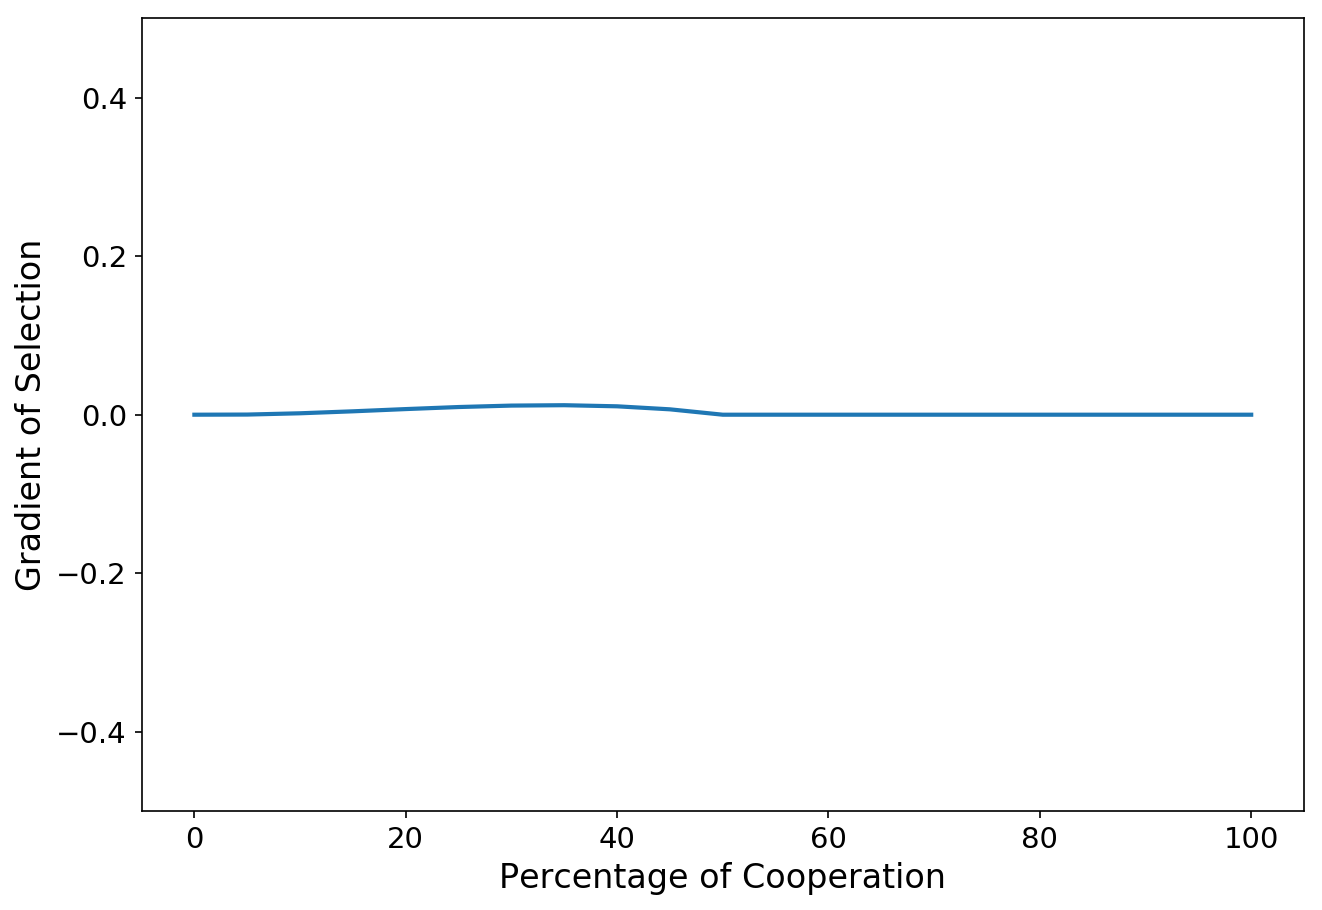

In [42]:
gradients=[]
coop_levels=np.arange(0,105,5)
beta=0.01
for coop in coop_levels:
    Tp,Tm=probIncreaseDecrease(coop,2,1)
    gradients.append(Tp-Tm)

garray=np.asarray(gradients)
figg = plt.figure(figsize=(10, 7), dpi=150)
lines=plt.plot(coop_levels,garray,'-')
plt.rc("font", size=14)
plt.setp(lines, linewidth=2.0)
plt.ylabel('Gradient of Selection',size=16)
plt.xlabel('Percentage of Cooperation',size=16)
plt.ylim(-0.5,0.5)
plt.show()

### Plot stationary distributions as a graph

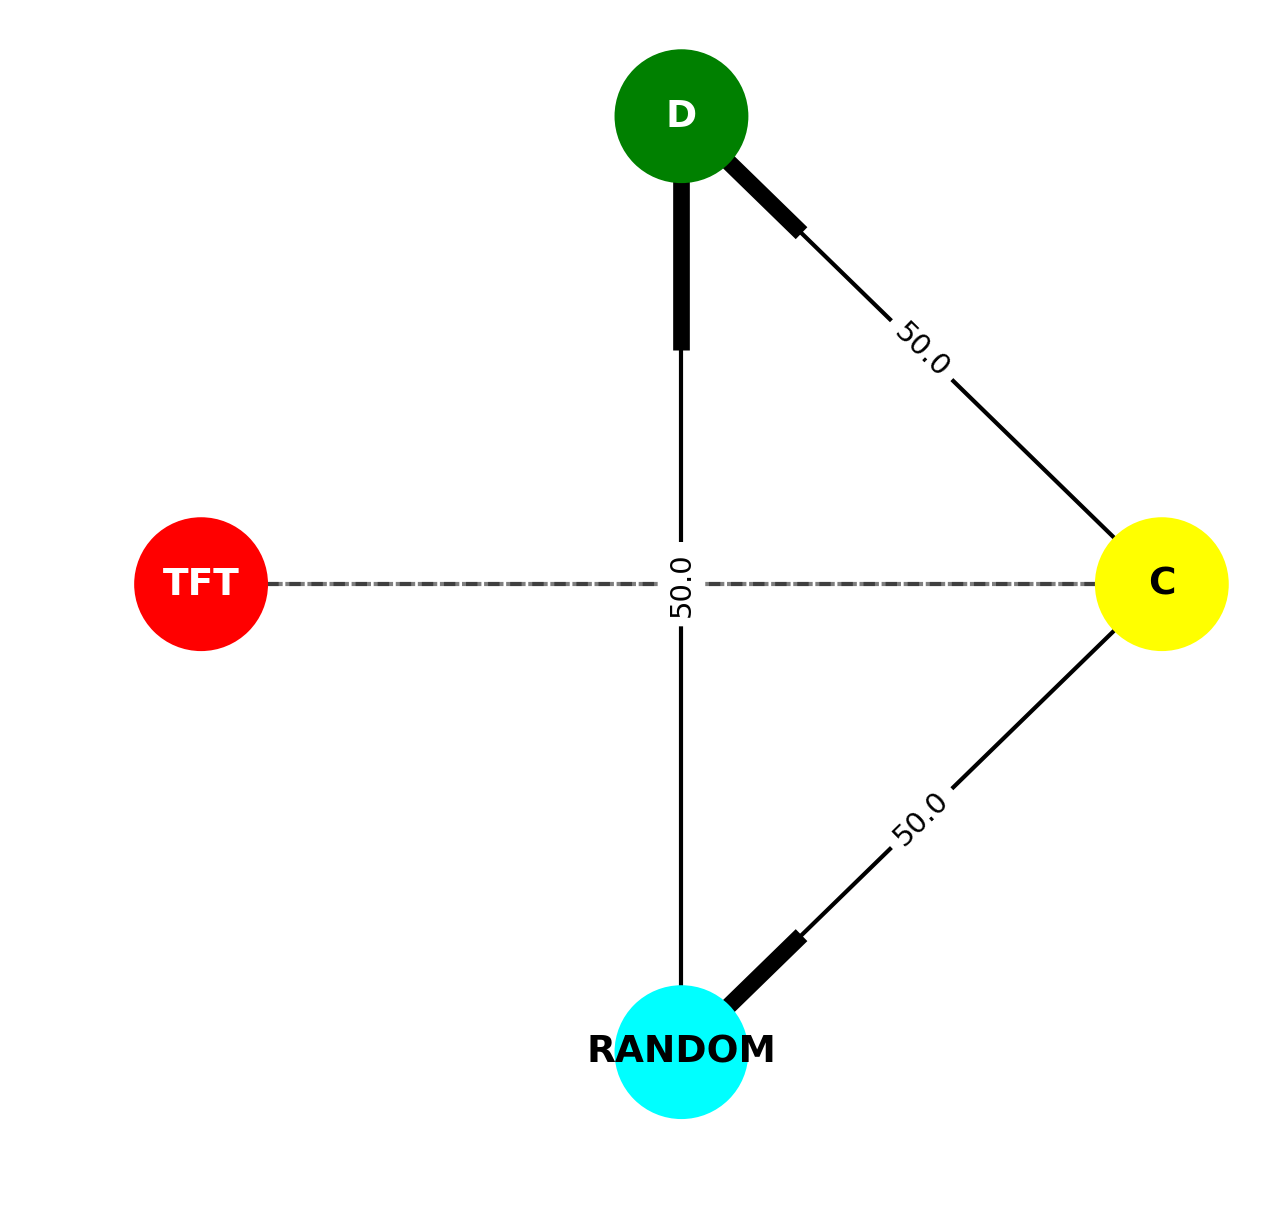

In [43]:
G=nx.DiGraph()
G.add_nodes_from(strats)
ncolors=['yellow','green','red','cyan']
beta = 0.01
for j in range(q):
    for i in range(q):
        if f[i,j] >= drift:
            G.add_edge(strats[i],strats[j],weight=f[i,j])


eselect=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1.0]
eselect_labels=dict(((u,v),float("{0:.2f}".format(d['weight']))) 
                    for (u,v,d) in G.edges(data=True) if d['weight'] >1.0)
edrift=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] ==1.0]

fig = plt.figure(figsize=(10, 10), dpi=150)


pos=nx.circular_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=4000,node_color=ncolors,with_labels=True)

# edges
nx.draw_networkx_edges(G,pos,edgelist=eselect,
                       edge_labels=eselect_labels,width=2,with_labels=True)
nx.draw_networkx_edges(G,pos,edgelist=edrift,
                       width=2,alpha=0.5,style='dashed',arrows=False)

# node labels
nx.draw_networkx_labels(G,pos,{'C':'C','RANDOM': 'RANDOM'},
                        font_size=18,font_weight='bold',font_color='black')
nx.draw_networkx_labels(G,pos,{'TFT':'TFT','D':'D'},
                        font_size=18,font_weight='bold',font_color='white')

#edge labels
nx.draw_networkx_edge_labels(G,pos,edge_labels=eselect_labels,font_size=14)

plt.axis('off')
plt.show() # display


#ONE ERROR REMAINS --- FAKE should be black and FREE should by cyan 
#node should contain value of stationary distribution